# Food Classifier Project
#### Created by Thierry LAPLANCHE

Contents :
1. Import libraries
2. Define constants related to the pictures
3. Define constants related to the model
4. Load pictures into memory and generate classes
5. Transfer learning : import the pre-trained model and re-train it with new data  
   5-a. Fine-tune hyperparameters with Keras Tuner (optional)  
   5-b. Train the model with a fixed set of hyperparameters
6. Save the model to a file
7. Evaluate the performance of the model
8. Visualize the predictions
9. Understand the predictions of the model

## 1. Import libraries

Let's import all the libraries we need.  
Uncomment the following line if you are missing some of the libraries.

In [2]:
#!pip install tensorflow==2.3.0 opencv-python numpy matplotlib pickle-mixin sklearn pandas seaborn keras-tuner
#!conda install Pillow

In [3]:
# TensorFlow/Keras libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

from collections import Counter # count items in a list
import cv2 # OpenCV: manipulate images
from PIL import ImageFile # Pillow: open and save images
import numpy as np # numpy: execute math operations
import matplotlib.pyplot as plt # pyplot: plot charts and drawings
import random # create a random number
import os # deal with files and folders
import os.path # deal with files and folders
import math # math operations
import pickle # pickle: read and write files on the system
from sklearn.metrics import classification_report, confusion_matrix # evaluate performance of the model 
import pandas as pd # data analysis
import seaborn as sns # data visualization

In [4]:
print("Current TensorFlow version: {}".format(tf.__version__))

Current TensorFlow version: 2.3.0


## 2. Define constants related to the pictures

In [5]:
# Paths to the training, validation and test datasets
TRAINING_DATA_DIR = 'images/train/'
VALIDATION_DATA_DIR = 'images/valid/'
TEST_DATA_DIR = 'images/test/'

Let's count how many pictures we have in our datasets.

In [6]:
TRAIN_SAMPLES = sum([len(filenames) for dirpath, dirnames, filenames in os.walk(TRAINING_DATA_DIR)])
VALIDATION_SAMPLES = sum([len(filenames) for dirpath, dirnames, filenames in os.walk(VALIDATION_DATA_DIR)])
TEST_SAMPLES = sum([len(filenames) for dirpath, dirnames, filenames in os.walk(TEST_DATA_DIR)])

print("Number of training samples : {}".format(TRAIN_SAMPLES))
print("Number of validation samples : {}".format(VALIDATION_SAMPLES))
print("Number of test samples : {}".format(TEST_SAMPLES))

Number of training samples : 2238
Number of validation samples : 200
Number of test samples : 200


How many different classes (= food items) do we have?

In [7]:
NUM_CLASSES = len(next(os.walk(TRAINING_DATA_DIR))[1])

print("Number of classes: {}".format(NUM_CLASSES))

Number of classes: 20


## 3. Define constants related to the model

We will define two additional constants:
- IMG_WIDTH, IMG_HEIGHT: Width and height of images that will be fed to the network. The pre-trained model on which we will execute transfer learning (ResNet-50) requires images of size (224x224) as an input.  
- BATCH_SIZE: Number of samples (pictures) to be processed in one training iteration. Increasing the batch size speeds us training, but requires more RAM.

In [8]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32 # You may increase this value to speed up training if your computing resources allow. If the execution of the training method 'model.fit' in step 5 fails, try to reduce this value.

## 4. Load pictures into memory and generate classes

The class "ImageDataGenerator" allows to load existing pictures and to generate new pictures to feed the model with more data.  
It applies different transformations to the existing pictures (rotation, shift, zoom, etc.).  
Such transformations should only be applied to training pictures, not validation or test pictures.

In [12]:
# Set Pillow to allow image files that are truncated -- necessary to avoid errors
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Create an ImageDataGenerator for training pictures with data augmentation (generation of new pictures)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30, # rotates pictures
                                   width_shift_range=0.2, # shifts pictures horizontally
                                   height_shift_range=0.2, # shifts pictures vertically
                                   horizontal_flip=True, # flips pictures horizontally
                                   brightness_range=[0.5,1.5], # adjust the brightness
                                   zoom_range=0.3) # zooms into pictures

# Create an ImageDataGenerator for validation and test pictures (no data augmentation is applied)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

Load pictures from their folders. Each folder corresponds to one type of food.  
Classes (names of food) are automatically created based on the name of the folder in which pictures are stored.

In [13]:
train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True, # Training pictures are shuffled to introduce more randomness during the training process
                                                    #seed=42,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(VALIDATION_DATA_DIR,
                                                       target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                       batch_size=BATCH_SIZE,
                                                       #shuffle=False,
                                                       shuffle=True,
                                                       class_mode='categorical')

Found 2238 images belonging to 20 classes.
Found 200 images belonging to 20 classes.


Let's create a dictionary which will contain the indice of the food item (0, 1, 2...) and the name of the food item.  
It is assumed that picture folders are named as : "001.Name of food". The class name will be "Name of food".

In [38]:
labels = (train_generator.class_indices) # get the dictionary which was automatically created when we loaded the pictures
labels = dict((v,k.split('.')[1]) for k,v in labels.items()) # inverse the keys and the values into a new dictionary

print("Indices and names of food items are stored as follows:\n\n{}".format(labels))

Indices and names of food items are stored as follows:

{0: 'Bak kuh teh pork rib soup', 1: 'Baklava', 2: 'Char kway teow', 3: 'Chilli crab', 4: 'Hummus', 5: 'Kanafeh', 6: 'Rojak', 7: 'Seafood hor fun', 8: 'Shawarma', 9: 'Tabouleh', 10: 'Ban mian', 11: 'Braised yee mee', 12: 'Fishball noodle', 13: 'Fish head bee hoon', 14: 'Fried carrot cake', 15: 'Hokkien mee', 16: 'Laksa curry noodle', 17: 'Mee goreng', 18: 'Mee rebus', 19: 'Nasi lemak'}


Let's take a look at the number of training images for each class to make sure that there is no imbalance.

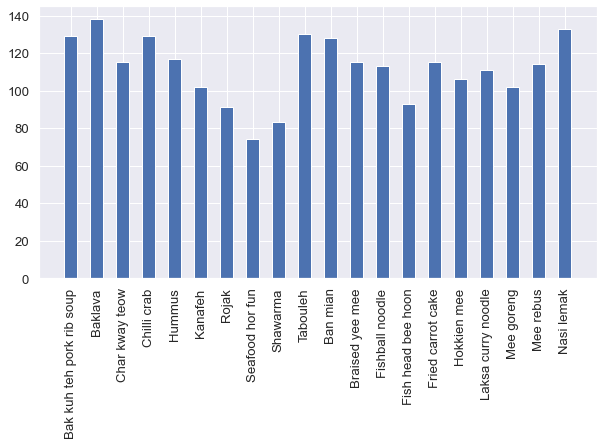

In [39]:
_, values = zip(*Counter(train_generator.labels).items()) # Count items in each class
indexes = np.arange(len(labels.values())) # Creates the horizontal axis

# Plot the diagram
plt.figure(figsize=(10,5))
plt.bar(indexes, values, 0.5)
plt.xticks(indexes, labels.values(), rotation='vertical')
plt.show()

## 5. Transfer learning : import the pre-trained model and re-train it with new data

If you previously saved a model and want to resume training, uncomment the following lines to load the model and its associated labels.

In [21]:
# Version of the model: number under the folder 'TFSavedModel' in which the model is saved
version = '1'

# Load the saved model
#model = tf.keras.models.load_model(os.path.join('TFSavedModel', version))

# Load the dictionary (labels)
#labels = pickle.load(open(os.path.join('TFSavedModel', version, 'labels.pickle'), "rb" ))

### 5-a. Fine-tune hyperparameters with Keras Tuner (optional)

Keras Tuner is a library that helps you pick the optimal set of hyperparameters for your model.  
There are a few built-in Tuner subclasses available for widely-used tuning algorithms: RandomSearch, BayesianOptimization and Hyperband.  
In this project, we will try out RandomSearch and Hyperband.  
First, we will define a function which builds the model and specifies which parameters will be tested out by Keras Tuner.

In [10]:
# Keras Tuner requires a model-building function which defines the range of values for each hyperparameter and returns the customized model
# The hyperparameters that will be tested are the following:
#   - number of units in the final Dense layer: range [32-512]
#   - dropout: range [0-0.5]
#   - learning rate: range [0.0001-0.01]
def build_model(hp):
    # Load the pre-trained ResNet50 model without the top layer (classifier)
    base_model = ResNet50(include_top=False,
                          input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # Freeze the weights of all layers (= make then non-trainable) except for the last 8 layers that will be retrained
    for layer in base_model.layers[:-8]:
        layer.trainable = False

    # Add new layers to the model    
    custom_model = GlobalAveragePooling2D()(base_model.output)
    custom_model = Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(custom_model) # number of units in the final Dense layer
    custom_model = Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.05))(custom_model) # dropout

    # Add the top layer (classifier), in which the number of neurons is equal to the number of classes we want to predict (= number of food items)
    # Since we have more than two classes, we choose 'softmax' as the activation function.
    custom_model = Dense(NUM_CLASSES, activation = 'softmax')(custom_model)

    model = Model(inputs=base_model.input, outputs=custom_model)
    
    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(
                  hp.Choice('learning_rate',
                            values=[1e-2, 1e-3, 1e-4])), # learning rate
                            metrics=[tf.keras.metrics.CategoricalAccuracy()]) # metrics: accuracy (accuracy will be used to evaluate the model performance)
  
    # Return the model
    return model

#### RandomSearch
RandomSearch randomly samples hyperparameter combinations (such as dropout and learning rate), tests them out sequentially, and returns the best set of combinations.  
It is a very time-consuming process, so you might skip this part and run the Hyperband tuning algorithm.

In [ ]:
# Configure the experiments to find the optimal combination of hyperparameters
tuner = RandomSearch(
    build_model,
    objective='val_categorical_accuracy',
    max_trials=15, # number of experiments (combinations)
    executions_per_trial=3, # number of training executions for each experiment
    directory='tuning_dir',
    project_name='tune_optimizer')

# Display search space summary
tuner.search_space_summary()

# Run the experiments
tuner.search(train_generator,
             steps_per_epoch = math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE),
             epochs=20,
             callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)],
             validation_data=validation_generator,
             validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

In [ ]:
# Retrieve the best hyperparameters found during the search: you may apply these values in the following part (5-b) and retrain the model based on these values
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("The hyperparameter search is complete."+
      "\nOptimal number of units: {}".format(best_hp.get('units')) +
      "\nOptimal dropout: {}".format(best_hp.get('dropout')) +
      "\nOptimal learning rate: {}".format(best_hp.get('learning_rate')))

In [ ]:
# Otherwise, you might directly retrieve the best model trained during tuning
model = tuner.get_best_models(1)[0]

#### Hyperband
The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model.  
Hyperband trains multiple models for a small number of epochs. After that, it picks the best performing models and continues training them for a few more epochs.  
In this way, we can save time compared with RandomSearch.

In [15]:
# Configure the experiments to find the optimal combination of hyperparameters
tuner = kt.Hyperband(build_model,
                     objective='val_categorical_accuracy',
                     max_epochs=25,
                     factor=3,
                     directory='tuning_dir',
                     project_name='food_classifier')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6) # EarlyStopping : stops training if validation loss doesn't improve after 'patience' number of epochs

In [ ]:
# Run the experiments
tuner.search(train_generator, epochs=50, validation_data=validation_generator, callbacks=[stop_early])

In [ ]:
# Retrieve the best hyperparameters found during the search: you may apply these values in the following part (5-b) and retrain the model based on these values
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("The hyperparameter search is complete."+
      "\nOptimal number of units: {}".format(best_hp.get('units')) +
      "\nOptimal dropout: {}".format(best_hp.get('dropout')) +
      "\nOptimal learning rate: {}".format(best_hp.get('learning_rate')))

In [ ]:
# Otherwise, you might directly retrieve the best model trained during tuning
model = tuner.get_best_models(1)[0]

### 5-b. Train the model with a fixed set of hyperparameters

If you skipped part 5-a, or if you want to retrain the model using the best hyperparameters found with Keras Tuner, you need to execute this part.  
Otherwise, if you already have trained your model in the variable 'model', you may skip to the following part.  
We will now load the pre-trained ResNet50 model into memory, and modify some of its layers to allow transfer learning.  
If you executed the previous step (Keras Tuner), you may replace the value of hyperparameters with their optimal value.

In [18]:
# Load the pre-trained ResNet50 model without the top layer (classifier)
base_model = ResNet50(include_top=False,
                      input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Freeze the weights of all layers (= make then non-trainable) except for the last 8 layers that will be retrained
for layer in base_model.layers[:-8]:
    layer.trainable = False

# Add new layers to the model    
custom_model = GlobalAveragePooling2D()(base_model.output)
custom_model = Dense(512, activation='relu')(custom_model) # number of units in the final Dense layer 
custom_model = Dropout(0.6)(custom_model) # dropout

# Add the top layer (classifier), in which the number of neurons is equal to the number of classes we want to predict (= number of food items)
# Since we have more than two classes, we choose 'softmax' as the activation function.
custom_model = Dense(NUM_CLASSES, activation = 'softmax')(custom_model)

model = Model(inputs=base_model.input, outputs=custom_model)

Before running the training, let's determine the learning rate we will apply.  
If the learning rate is too small, it will take too many training epochs for the model to learn anything.  
If it is too large, the model may fail to find the optimal values because the evolution between each epoch will be too important.  
It might be a good option to start the training with a larger learning rate and then decrease it gradually. That is possible thanks to learning rate decay.

In [19]:
# Define an Exponential Decay for the learning rate
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-2, # 0.01
    decay_steps=math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE),
    decay_rate=0.9, # around 0.8~0.9
    staircase=True)
    
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Otherwise, to use a fixed learning rate, uncomment the following line
# optimizer=tf.keras.optimizers.Adam(lr=0.001), # lr: Learning rate

Now, we will compile the model and "fit" it to the training generator, which means that the generator will feed the model with pictures.  
Validation data (from the validation generator) allows to analyze the evolution of the model performance at each step of the training.  
Since we have more than two classes, we choose 'categorical_crossentropy' as the loss function.  
  
This step might take hours to complete depending on your resources.

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=[tf.keras.metrics.CategoricalAccuracy()]) # metrics: accuracy (accuracy will be used to evaluate the model performance)

# Train the model
model.fit(train_generator,
          steps_per_epoch = math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE), # number of steps per training epoch = total number of training pictures / batch size
          validation_data = validation_generator,
          validation_steps = math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE), # number of steps for validation = total number of validations pictures / batch size
          epochs=30, # number of epochs : you may increase this value to make the training longer, but it might result in overfitting of the model
          verbose=1)

## 6. Save the model to a file

Now that the model is trained, we will save it to a file. Calling the method 'save()' will save:
- The architecture of the model
- The weights of the model
- The training configuration (loss, optimizer)

In [ ]:
# Version of the model: you may keep the version to '1' even if you update the model since Azure ML uses its own versioning system
# This value needs to be equal to the value of global variable 'version' in the entry script ('development/entry_script.py')
version = '1'

# Save the model to Keras HDF5 format (for backup purposes only -- it will not be used)
model.save(os.path.join('HDF5Model', 'model-finetuned.h5'), save_format='h5')
           
# Save the model to TensorFlow format (for deployment to a cloud platform)
model.save(os.path.join('TFSavedModel', version), save_format='tf')

# Save the dictionary (labels) to a file in the same folder as the model
pickle.dump(labels, open(os.path.join('TFSavedModel', version, 'labels.pickle'), 'wb'))

## 7. Evaluate the performance of the model

Let's now evaluate the model based on both validation and test sets.  
First, we will calculate the validation accuracy, which is based on pictures that the model has seen during training.

In [22]:
score = model.evaluate(validation_generator)
print("Validation accuracy : {:.2f} %".format(score[1]*100))

7/7 [==============================] - 8s 1s/step - loss: 0.6586 - categorical_accuracy: 0.8400
Validation accuracy : 84.00 %


Accuracy = number of correct predictions / number of total predictions  
  
What about accuracy on the test set, which is based on pictures that the model has never seen before?

In [23]:
# Load images from the test folder
test_generator = val_datagen.flow_from_directory(TEST_DATA_DIR,
                                                 target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 class_mode='categorical')

Found 200 images belonging to 20 classes.


In [24]:
score = model.evaluate(test_generator)
print("Test accuracy : {:.2f} %".format(score[1]*100))

7/7 [==============================] - 6s 862ms/step - loss: 0.6457 - categorical_accuracy: 0.8300
Test accuracy : 83.00 %


Test accuracy can be a bit lower than validation accuracy, but it should not be too different.

Let's generate a few more evaluation metrics on the test set: 
- A confusion matrix is a summary of prediction results on a classification problem: it shows how many samples were correctly guessed for each class (the diagonal of the matrix), and the misclassified samples.
- A classification report shows the main classification metrics (precision, recall, F1 score) for each class.

In [25]:
# Get class predictions on the test dataset
predictions = model.predict(test_generator)

# Get the list of top predictions (index of class with highest probability) for all images
top_index = np.argmax(predictions, axis=1)

# Compute the confusion matrix: the horizontal axis shows the predicted classes, the vertical axis shows the actual class
matrix = confusion_matrix(test_generator.classes, top_index)

In [26]:
# Display the confusion matrix
matrix

array([[ 9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0],
       [ 0,  9,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,
         0,  2,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  8,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  8,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0

The confusion matrix might be too large to be displayed entirely here. We will slice it and make it more visually pleasant.  
Before that, let's take a look at the first column of the matrix (column 0), which shows the number of images from each class that were classified (correctly or incorrectly) as class no. 0 (the first food item).  
You may try to replace 0 by another class index.

In [27]:
print(matrix[:,0])

[9 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


The first number shows the number of pictures from class 0 that were actually classified as class 0.  
  
Now let's look at the first line of the matrix (line 0), which shows in which class the pictures belonging to class 0 were classified by the model.  
Ideally, they should have all been classified in class 0.

In [28]:
print(matrix[0])

[9 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


The first number shows how many pictures from class 0 were actually classified as class 0.

 
Let's slice the matrix and display it more nicely using the Seaborn library.

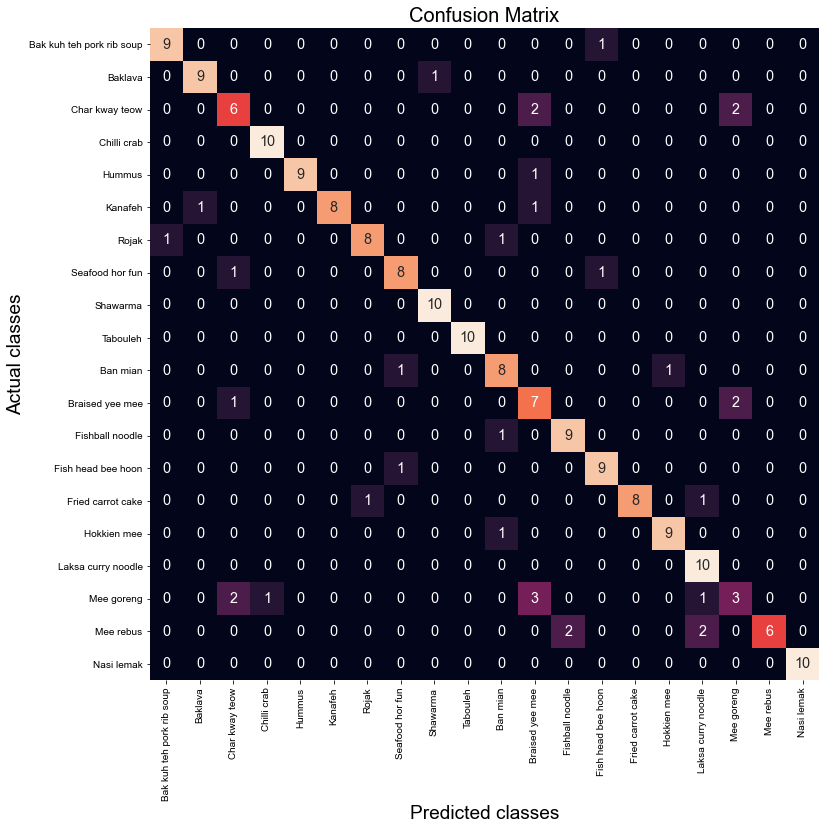

In [29]:
# Build a Pandas dataframe with the confusion matrix as values and the classes as row/column names
df_matrix = pd.DataFrame(matrix, index=labels.values(), columns=labels.values())

# Plot a slice of the confusion matrix (the first 10 classes only -- in case there are more than 10 food items)
fig, ax = plt.subplots(figsize=(12,12)) # size of the diagram
sns.set(font_scale=1.2)
sns.heatmap(df_matrix.iloc[0:20,0:20], annot=True, cbar=False, ax=ax) # slice the confusion matrix from class 0 to class 9

plt.title('Confusion Matrix', fontsize = 20)
plt.xlabel('Predicted classes', fontsize = 19)
plt.ylabel('Actual classes', fontsize = 19)
plt.show()

By looking at the diagonal, we can verify how many pictures of each class were correctly classified.
  
And now, let's compute the classification report which shows:
- Precision : Number of positive class predictions that actually belong to the positive class (What proportion of positive class predictions was actually correct?)  
  Precision = True positives / (True positives + False positives)  
   
- Recall : Number of positive class predictions made out of all positive examples in the dataset (What proportion of actual positives was identified correctly?)  
  Recall = True positives / (True positives + False negatives)  
   
- F1-score : Weighted average of precision and recall  
  F1-score = 2*(Recall * Precision) / (Recall + Precision)  
    
For example, if we get a precision of 0.78 and a recall of 0.70 for a certain class (let's say class A), it means:  
- 78 % of pictures that were classified as class A actually belong to class A. The remaining 22 % were mistaken for class A.
- 70 % of all class A pictures were correctly classified as class A.  

In [30]:
print('Classification Report')
print(classification_report(test_generator.classes, top_index, target_names=labels.values()))

Classification Report
                           precision    recall  f1-score   support

Bak kuh teh pork rib soup       0.90      0.90      0.90        10
                  Baklava       0.90      0.90      0.90        10
           Char kway teow       0.60      0.60      0.60        10
              Chilli crab       0.91      1.00      0.95        10
                   Hummus       1.00      0.90      0.95        10
                  Kanafeh       1.00      0.80      0.89        10
                    Rojak       0.89      0.80      0.84        10
          Seafood hor fun       0.80      0.80      0.80        10
                 Shawarma       0.91      1.00      0.95        10
                 Tabouleh       1.00      1.00      1.00        10
                 Ban mian       0.73      0.80      0.76        10
          Braised yee mee       0.50      0.70      0.58        10
          Fishball noodle       0.82      0.90      0.86        10
       Fish head bee hoon       0.82   

## 8. Visualize the predictions

Let's visualize some predictions along with the pictures.

In [31]:
# Function to randomly select, pre-process pictures from a certain PATH and run the model to make predictions on those pictures
def pick_pictures(path, columns, rows):
    # Create a matplotlib figure
    fig=plt.figure(figsize=(20, 12))
    ax = []
    
    # Browse files in the PATH directory
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(path):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    
    # Randomly pick a certain number of pictures (equal to columns*rows) from the list
    files = random.sample(range(len(listOfFiles)), columns*rows)
    
    for i in range(columns*rows):
        # Transform the image into a Tensor to be passed to the model
        img = image.load_img(listOfFiles[files[i]], target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        
        # Get predictions from the model
        prediction = model.predict(img_preprocessed)
        
        # Retrieve the class index for the top two guesses (the most probable classes)
        
        first_index = prediction.argsort()[0][-1]
        second_index = prediction.argsort()[0][-2]
        
        # Plot the results in an ordered fashion
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title("Probably a {}".format(labels[first_index]) + # name of the class with highest probability
                         "\n({:.2f} % chance)".format(prediction[0][first_index]*100) + # probability of the class with highest probability
                         "\n\nPossibly a {}".format(labels[second_index]) + # name of the class with second highest probability
                         "\n({:.2f} % chance)".format(prediction[0][second_index]*100) #+ # probability of the class with second highest probability
                         #"\n\nGround truth: {}".format(listOfFiles[files[i]].split("/")[2].split(".")[1].split("\\")[0])
                        )
        
        plt.axis('off')
        plt.imshow(img)

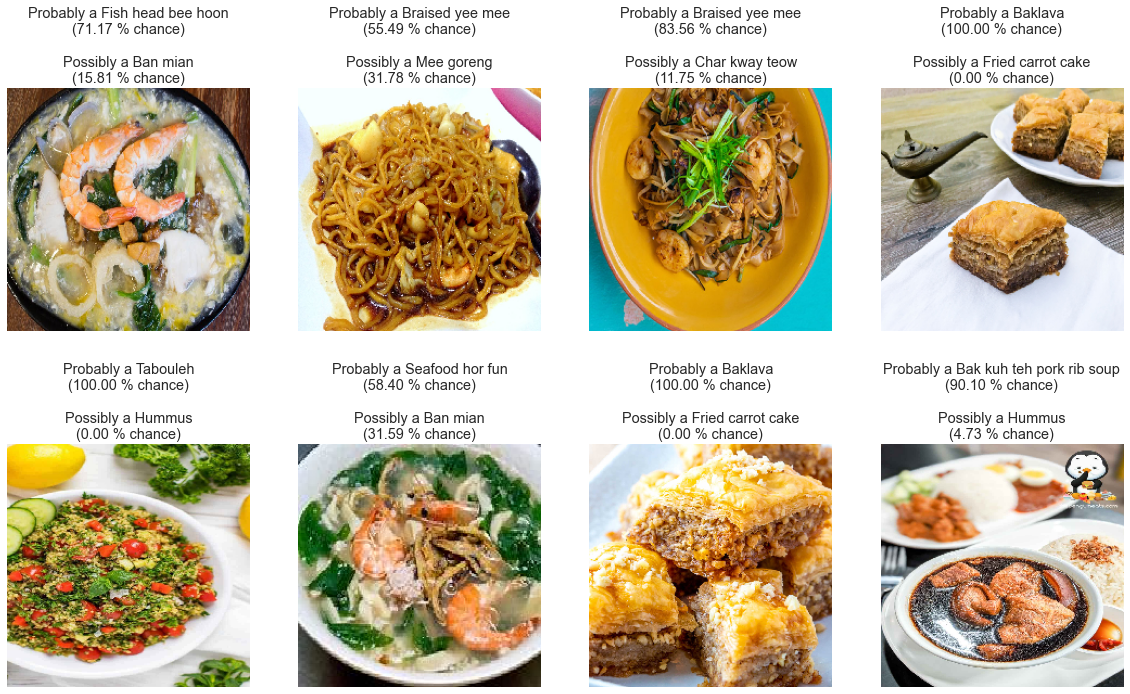

In [33]:
#########################################################
# ENTER THE NAME OF THE PATH FROM WHERE TO PICK PICTURES
PATH = 'images/test/'
#########################################################

COLUMNS = 4 # number of columns to display
ROWS = 2 # number of rows to display

pick_pictures(PATH, COLUMNS, ROWS)

## 9. Understand the predictions of the model

Finally, let's look at which parts in an image are considered as important by the model to classify the picture in a certain class.  
The "Grad-CAM" relies on the gradients in the final convolutional layer of the model to produce a heatmap highlighting the important regions in the image for predicting the class.  
The parts marked in red are the ones which helped the model classify the picture.

In [42]:
# Function to compute and display Grad-CAM
def grad_cam(path, class_index, layer):
    # path: path to the image file
    # class_index: ground truth class
    # layer: name of the last convolutional layer of the model
    
    img = image.load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_arr = image.img_to_array(img)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img_arr]))
        loss = predictions[:, class_index]

    output = conv_outputs[0]

    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    output_image = cv2.addWeighted(cv2.cvtColor(img_arr.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

    fig=plt.figure(figsize=(10, 10))
    
    ax = []
    
    # Display the image
    ax.append(fig.add_subplot(1, 2, 1))
    ax[-1].set_title("Original Image")
    plt.imshow(img)
    plt.axis('off')
    
    # Display the Grad-CAM
    ax.append(fig.add_subplot(1, 2, 2))
    ax[-1].set_title("Grad CAM")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

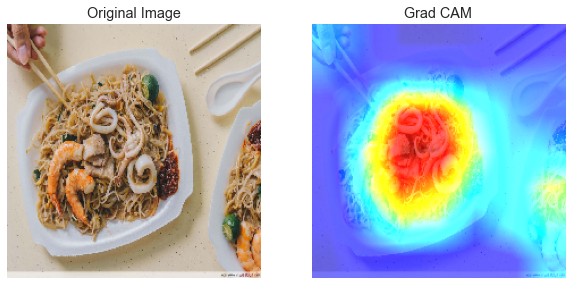

In [51]:
############################
# ENTER THE PATH OF AN IMAGE
############################
IMAGE_PATH = 'images/test/016.Hokkien mee/hokkien mee_105.jpeg' # path of the image file

##############################
# ENTER THE INDEX OF THE CLASS
##############################
CLASS_IDX = 15 # index of the class corresponding to the image (the class for the image folder starting with '001' is 0)

LAYER_NAME = 'conv5_block3_out' # name of the last convolutional layer of the model
grad_cam(IMAGE_PATH, CLASS_IDX, LAYER_NAME)

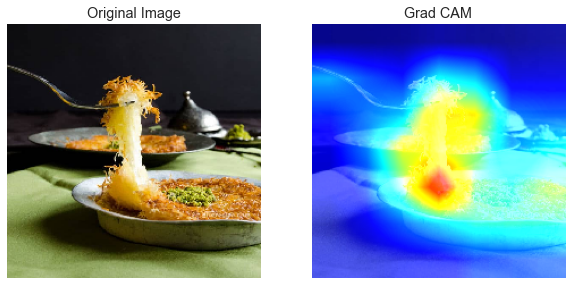

In [53]:
############################
# ENTER THE PATH OF AN IMAGE
############################
IMAGE_PATH = 'images/test/006.Kanafeh/49.jpeg' # path of the image file

##############################
# ENTER THE INDEX OF THE CLASS
##############################
CLASS_IDX = 5 # index of the class corresponding to the image (the class for the image folder starting with '001' is 0)

LAYER_NAME = 'conv5_block3_out' # name of the last convolutional layer of the model
grad_cam(IMAGE_PATH, CLASS_IDX, LAYER_NAME)